In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ocd-patient-dataset-demographics-and-clinical-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3980726%2F6932567%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240619%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240619T222403Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7d361690e784221a9389e0f06f20f011c8a56e25781bb2f1e551fa30209f0778a47fbb59ec15c548566686e9027f51452b028631c519fdb41fcf0fa99e8f1201508946503e3fac1a55084e35af8eff68c206b0aaa3b3198b3812a0cde52ae5e6eea1bb0072287c857b2a233d3ff87caf1e8fd7055af68a759706f832062d0f709a372333a33cae16d4f334bc9b14e93fd75618cbd896a06b0ac419d68cd5dcede3132256ea59eeeee42f6fa26dfca0683a05d4c7ecda09d7064631bf5a447305154af1e16ac2d0ebbde989c17558bcec251fb3962565da8c1acdd160251a47620f61a24d4da727937900fba4e636bd0bc8fe1385914027c10d8a0c94a2f56cb4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 31867 bytes downloaded
Downloaded and uncompressed: ocd-patient-dataset-demographics-and-clinical-data
Data source import complete.


# Analyzing Demographic and Behavioral Patterns in OCD Patients through Partitional Clustering

![](https://img.freepik.com/free-photo/portrait-student-girl-sitting-desk-biting-her-fist_1163-2568.jpg?w=996&t=st=1702684508~exp=1702685108~hmac=89b982682dc431b551d444897e744ca0269d956a6de4592a9b4552c68112ea67)

Image Source: <a href="https://www.freepik.com/free-photo/portrait-student-girl-sitting-desk-biting-her-fist_1281607.htm#query=ocd&position=9&from_view=keyword&track=sph&uuid=c7a08839-2cbd-4964-9991-9a8f7f03b7a8">Image by yanalya</a> on Freepik

# Data Loading and Cleaning

In [2]:
# import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
# laod the dataset
data = pd.read_csv('/kaggle/input/ocd-patient-dataset-demographics-and-clinical-data/ocd_patient_dataset.csv')

# check the dimension of the dataset
print('Dataset dimension: ', data.shape)

# check the attributes in the dataset
print('Attributes in the dataset: ', data.columns.values)

# view first 5 rows of the dataset
data.head()

Dataset dimension:  (1500, 17)
Attributes in the dataset:  ['Patient ID' 'Age' 'Gender' 'Ethnicity' 'Marital Status'
 'Education Level' 'OCD Diagnosis Date' 'Duration of Symptoms (months)'
 'Previous Diagnoses' 'Family History of OCD' 'Obsession Type'
 'Compulsion Type' 'Y-BOCS Score (Obsessions)'
 'Y-BOCS Score (Compulsions)' 'Depression Diagnosis' 'Anxiety Diagnosis'
 'Medications']


,Patient ID,Age,Gender,Ethnicity,Marital Status,Education Level,OCD Diagnosis Date,Duration of Symptoms (months),Previous Diagnoses,Family History of OCD,Obsession Type,Compulsion Type,Y-BOCS Score (Obsessions),Y-BOCS Score (Compulsions),Depression Diagnosis,Anxiety Diagnosis,Medications
0,1018,32,Female,African,Single,Some College,2016-07-15,203,MDD,No,Harm-related,Checking,17,10,Yes,Yes,SNRI
1,2406,69,Male,African,Divorced,Some College,2017-04-28,180,NaN,Yes,Harm-related,Washing,21,25,Yes,Yes,SSRI
2,1188,57,Male,Hispanic,Divorced,College Degree,2018-02-02,173,MDD,No,Contamination,Checking,3,4,No,No,Benzodiazepine
3,6200,27,Female,Hispanic,Married,College Degree,2014-08-25,126,PTSD,Yes,Symmetry,Washing,14,28,Yes,Yes,SSRI
4,5824,56,Female,Hispanic,Married,High School,2022-02-20,168,PTSD,Yes,Hoarding,Ordering,39,18,No,No,NaN


#### Attributes Description:

1. Patient ID - Unique identifier for each individual in the dataset.
2. Age - Age of the patient at the time of data collection.
3. Gender - Gender of the patient
4. Ethnicity - Ethnic background of the patient
5. Marital Status - Marital status of the patient
6. Education Level - Highest level of education completed by the patient.
7. OCD Diagnosis Date - Date when the patient was diagnosed with Obsessive-Compulsive Disorder.
8. Duration of Symptoms (months) - Number of months since the onset of OCD symptoms.
9. Previous Diagnoses - Any previous psychiatric diagnoses or comorbidities.
10. Family History of OCD - Indicates whether there is a family history of OCD in the patient's relatives.
11. Obsession Type -
12. Compulsion Type -
13. Y-BOCS Score (Obsessions) -
14. Y-BOCS Score (Compulsions) -
15. Depression Diagnosis - Diagnosis of depression (Yes or No)
16. Anxiety Diagnosis - Diagnosis of anxiety (Yes or No)
17. Medications - Type of medications use

In [4]:
# top level overview of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Patient ID                     1500 non-null   int64 
 1   Age                            1500 non-null   int64 
 2   Gender                         1500 non-null   object
 3   Ethnicity                      1500 non-null   object
 4   Marital Status                 1500 non-null   object
 5   Education Level                1500 non-null   object
 6   OCD Diagnosis Date             1500 non-null   object
 7   Duration of Symptoms (months)  1500 non-null   int64 
 8   Previous Diagnoses             1252 non-null   object
 9   Family History of OCD          1500 non-null   object
 10  Obsession Type                 1500 non-null   object
 11  Compulsion Type                1500 non-null   object
 12  Y-BOCS Score (Obsessions)      1500 non-null   int64 
 13  Y-B

In [5]:
# remove 'Patient ID' from analysis
data.drop(columns=['Patient ID'], axis=1, inplace=True)

# rename columns
data.rename({'Marital Status':'MaritalStatus',
            'Education Level':'EducationLevel',
            'OCD Diagnosis Date':'DiagnosisDate',
            'Duration of Symptoms (months)':'SymptomsDuration',
            'Previous Diagnoses':'PreviousDiagnoses',
            'Family History of OCD':'FamilyHistory',
            'Obsession Type':'ObsessionType',
            'Compulsion Type':'CompulsionType',
            'Y-BOCS Score (Obsessions)':'ObsessionScore',
            'Y-BOCS Score (Compulsions)':'CompulsionScore',
            'Depression Diagnosis':'DepressionDiagnosis',
            'Anxiety Diagnosis':'AnxietyDiagnosis'}, axis=1, inplace=True)

# relocate column 'DiagnosisDate'
diagnosed_date = data.pop('DiagnosisDate')
data.insert(0, 'DiagnosisDate', diagnosed_date)

# convert the data type 'DiagnosisDate' to datetime
data['DiagnosisDate'] = pd.to_datetime(data['DiagnosisDate'], format='%Y-%m-%d')

In [6]:
data.PreviousDiagnoses.unique()

array(['MDD', nan, 'PTSD', 'GAD', 'Panic Disorder'], dtype=object)

In [7]:
data.head()

,DiagnosisDate,Age,Gender,Ethnicity,MaritalStatus,EducationLevel,SymptomsDuration,PreviousDiagnoses,FamilyHistory,ObsessionType,CompulsionType,ObsessionScore,CompulsionScore,DepressionDiagnosis,AnxietyDiagnosis,Medications
0,2016-07-15,32,Female,African,Single,Some College,203,MDD,No,Harm-related,Checking,17,10,Yes,Yes,SNRI
1,2017-04-28,69,Male,African,Divorced,Some College,180,NaN,Yes,Harm-related,Washing,21,25,Yes,Yes,SSRI
2,2018-02-02,57,Male,Hispanic,Divorced,College Degree,173,MDD,No,Contamination,Checking,3,4,No,No,Benzodiazepine
3,2014-08-25,27,Female,Hispanic,Married,College Degree,126,PTSD,Yes,Symmetry,Washing,14,28,Yes,Yes,SSRI
4,2022-02-20,56,Female,Hispanic,Married,High School,168,PTSD,Yes,Hoarding,Ordering,39,18,No,No,NaN


# Data Preprocessing

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# categorical columns
categorical_features = ['Gender', 'Ethnicity', 'MaritalStatus', 'EducationLevel','PreviousDiagnoses','FamilyHistory',
                        'ObsessionType','CompulsionType','DepressionDiagnosis','AnxietyDiagnosis','Medications']

# numeric columns
numeric_features = ['Age', 'SymptomsDuration', 'ObsessionScore', 'CompulsionScore']

# create transformers
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder())
])

numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=2))
])

# create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ], remainder='passthrough')

# create the final pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('scaler', MinMaxScaler())])

In [9]:
# transform the data
df = data.drop(columns=['DiagnosisDate'], axis=1)
data_processed = pipeline.fit_transform(df)

# Partional Clustering: K-means Clustering

In [10]:
# compute the SSE for cluster range from 1 to 20
from sklearn.cluster import KMeans

sse = []
for k in range(1,21):
    km = KMeans(n_clusters=k, n_init=15, random_state=122)
    km.fit(data_processed)
    sse.append(km.inertia_)

res = pd.DataFrame({'Cluster':range(1,21), 'SSE':sse})

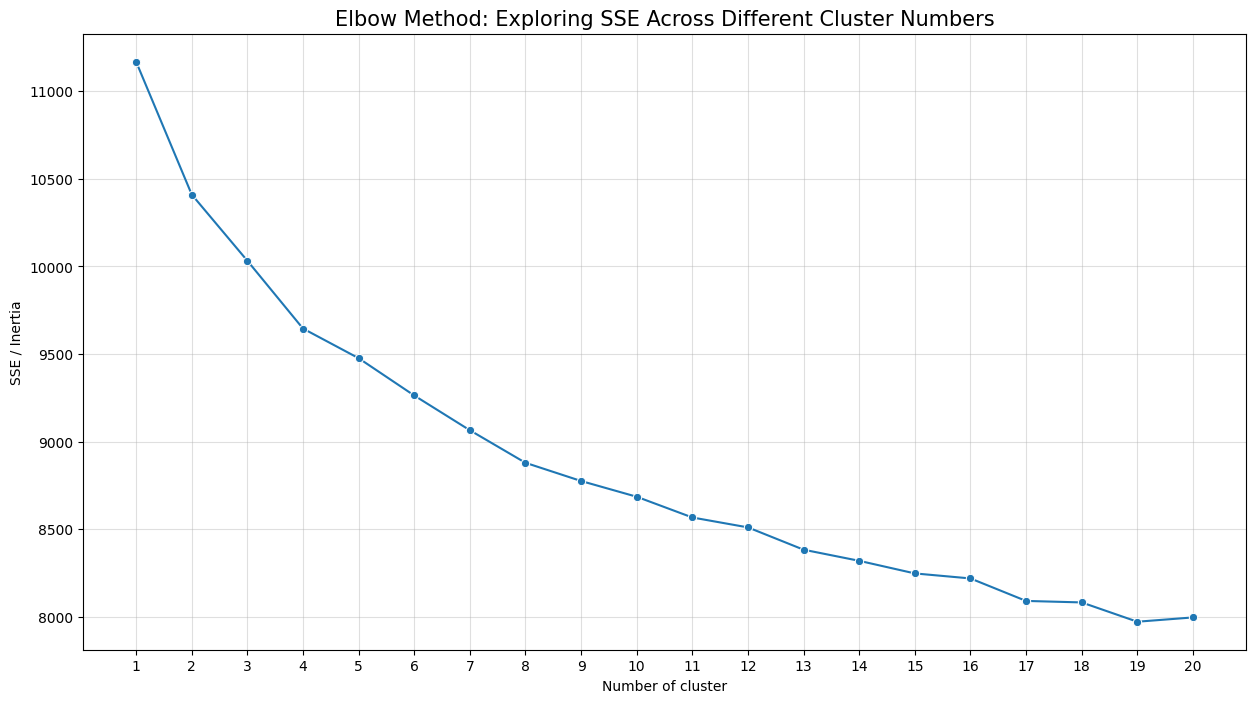

In [11]:
# visualize the SSE of different k value
plt.figure(figsize=(15,8))
sns.lineplot(data=res, x=res['Cluster'], y=res['SSE'], marker='o')
plt.xticks(range(1,21))
plt.xlabel('Number of cluster')
plt.ylabel('SSE / Inertia')
plt.title('Elbow Method: Exploring SSE Across Different Cluster Numbers', fontsize=15)
plt.grid(alpha=0.4)
plt.show()

In [12]:
km4 = KMeans(n_clusters=4, n_init=15, random_state=122)
km4.fit(data_processed)

KMeans(n_clusters=4, n_init=15, random_state=122)

In [13]:
# check the number of customer in each classes
km4.labels_
patientLabel = pd.Series(km4.labels_)
patientLabel.value_counts().sort_index()

0    376
1    349
2    375
3    400
Name: count, dtype: int64

In [14]:
# insert a new column 'Cluster' into the dataset
# this column contains the Cluster number of each patient assigned using the K-means partitional clustering
data['Cluster'] = patientLabel

# view the first 5 rows of the data with new column inserted
data.head()

,DiagnosisDate,Age,Gender,Ethnicity,MaritalStatus,EducationLevel,SymptomsDuration,PreviousDiagnoses,FamilyHistory,ObsessionType,CompulsionType,ObsessionScore,CompulsionScore,DepressionDiagnosis,AnxietyDiagnosis,Medications,Cluster
0,2016-07-15,32,Female,African,Single,Some College,203,MDD,No,Harm-related,Checking,17,10,Yes,Yes,SNRI,2
1,2017-04-28,69,Male,African,Divorced,Some College,180,NaN,Yes,Harm-related,Washing,21,25,Yes,Yes,SSRI,0
2,2018-02-02,57,Male,Hispanic,Divorced,College Degree,173,MDD,No,Contamination,Checking,3,4,No,No,Benzodiazepine,1
3,2014-08-25,27,Female,Hispanic,Married,College Degree,126,PTSD,Yes,Symmetry,Washing,14,28,Yes,Yes,SSRI,0
4,2022-02-20,56,Female,Hispanic,Married,High School,168,PTSD,Yes,Hoarding,Ordering,39,18,No,No,NaN,1


# Exploratory Data Analysis (EDA) - Characteristics of Different Clusters
#### Characteristic 1 | Patient's Age in Each Cluster

<ipython-input-15-2414c10b3c0e>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=data['Cluster'], y=data['Age'], palette=colors, ax=axes[1])


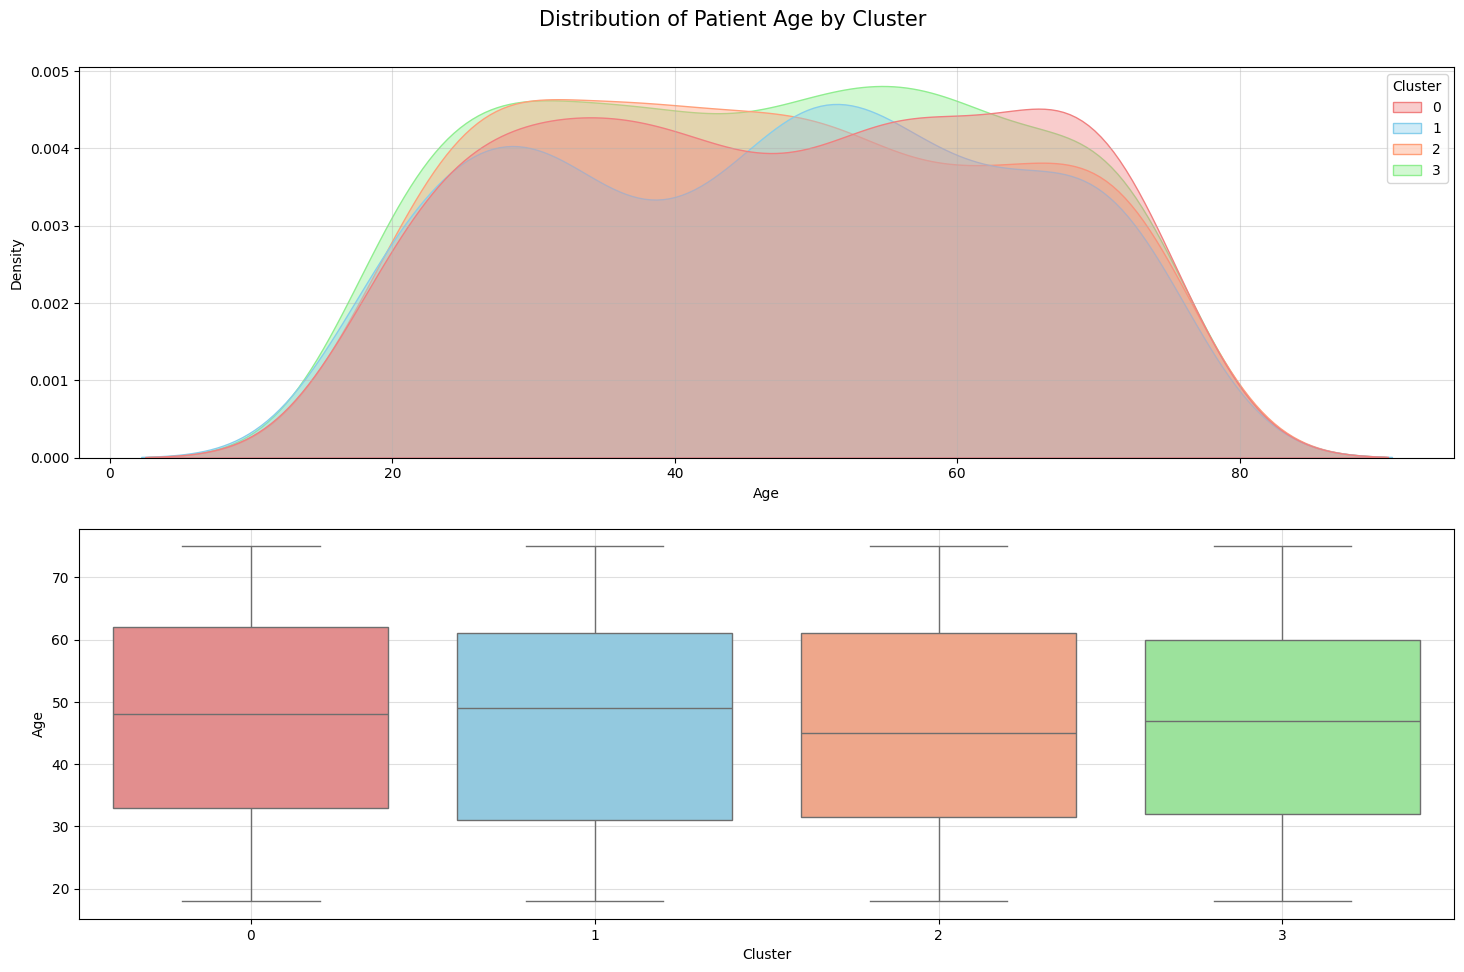

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,376.0,47.452128,16.899478,18.0,33.0,48.0,62.0,75.0
1,349.0,46.773639,16.954903,18.0,31.0,49.0,61.0,75.0
2,375.0,46.280000,16.734766,18.0,31.5,45.0,61.0,75.0
3,400.0,46.627500,16.788340,18.0,32.0,47.0,60.0,75.0


In [15]:
# distribution of patient age in each cluster
colors = ['lightcoral','skyblue','lightsalmon','lightgreen']

figure, axes = plt.subplots(2,1, figsize=(15,10))
sns.kdeplot(data=data, x=data['Age'], hue=data['Cluster'], palette=colors, fill=True, alpha=0.4, ax=axes[0])
axes[0].grid(alpha=0.4)
sns.boxplot(data=data, x=data['Cluster'], y=data['Age'], palette=colors, ax=axes[1])
axes[1].grid(alpha=0.4)
figure.suptitle('Distribution of Patient Age by Cluster', fontsize=15)
plt.tight_layout(pad=2)
plt.show()

# display the summary statistic
pt_cluster = data.groupby('Cluster')
display(pt_cluster.Age.describe())

#### Characteristic 2 | Duration of Symptoms of the Patients in each Cluster

<ipython-input-16-40d5e35726b2>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=data['Cluster'], y=data['SymptomsDuration'], palette=colors, ax=axes[1])


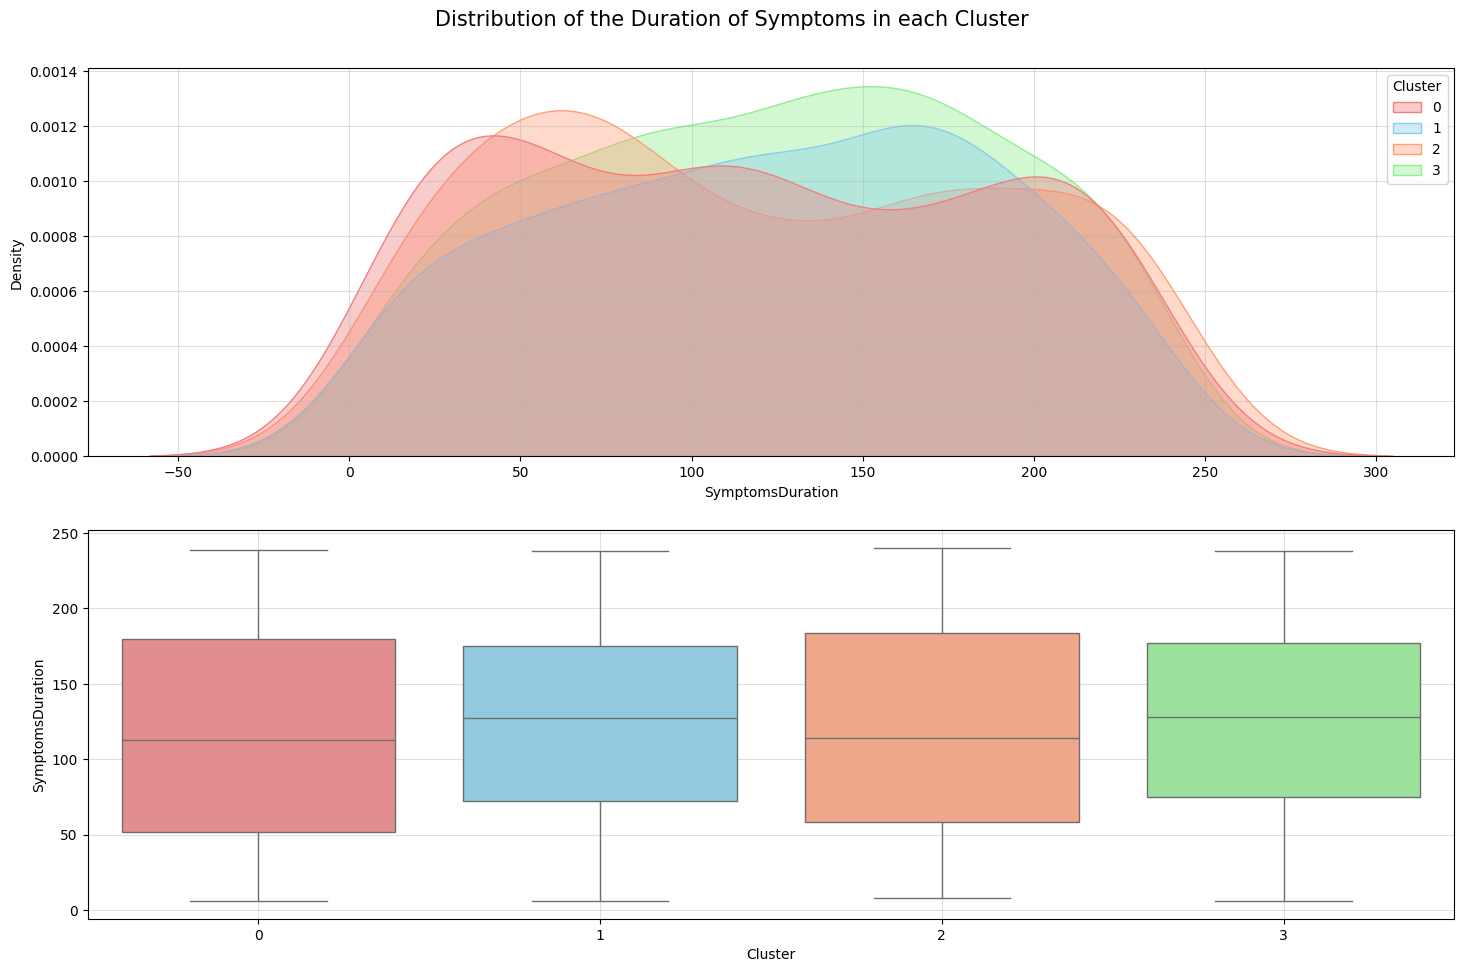

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,376.0,117.055851,70.254278,6.0,52.0,113.0,180.0,239.0
1,349.0,124.183381,64.162515,6.0,72.0,127.0,175.0,238.0
2,375.0,119.832000,70.721084,8.0,58.5,114.0,183.5,240.0
3,400.0,125.820000,64.074108,6.0,75.0,128.0,177.0,238.0


In [16]:
# distribution of duration of the symptoms in each cluster
figure, axes = plt.subplots(2,1, figsize=(15,10))
sns.kdeplot(data=data, x=data['SymptomsDuration'], hue=data['Cluster'], palette=colors, fill=True, alpha=0.4, ax=axes[0])
axes[0].grid(alpha=0.4)
sns.boxplot(data=data, x=data['Cluster'], y=data['SymptomsDuration'], palette=colors, ax=axes[1])
axes[1].grid(alpha=0.4)
figure.suptitle('Distribution of the Duration of Symptoms in each Cluster', fontsize=15)
plt.tight_layout(pad=2)
plt.show()

# display the summary statistic
pt_cluster = data.groupby('Cluster')
display(pt_cluster.SymptomsDuration.describe())

#### Characteristic 3 | Patien's Obession Score in each Cluster

<ipython-input-17-1c36fdbc9c21>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=data['Cluster'], y=data['ObsessionScore'], palette=colors, ax=axes[1])


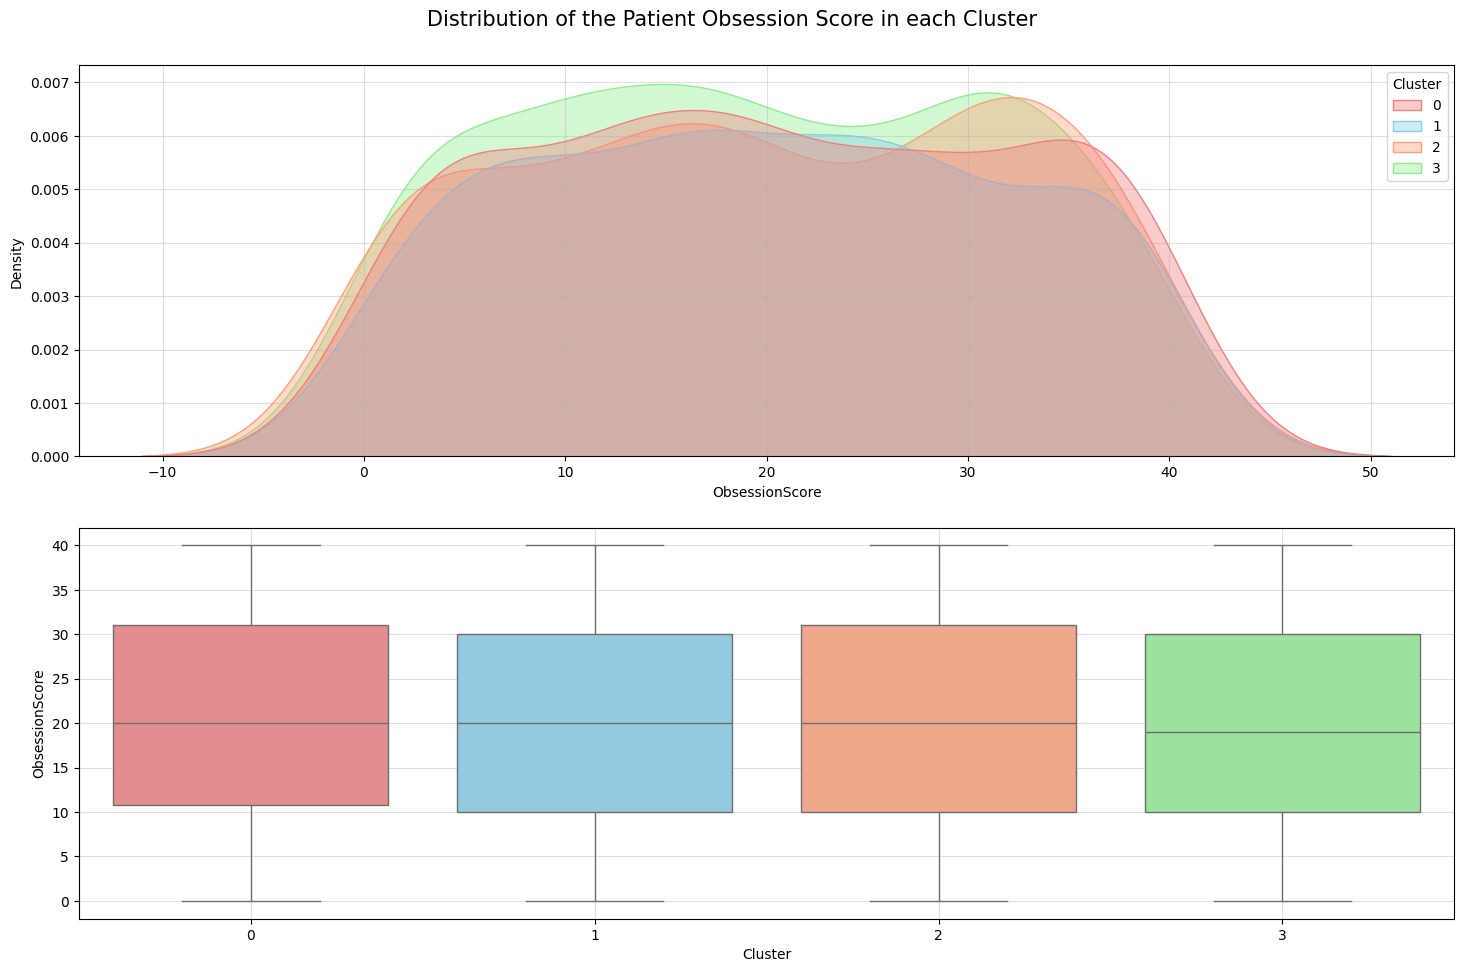

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,376.0,20.340426,11.941013,0.0,10.75,20.0,31.0,40.0
1,349.0,20.106017,11.651436,0.0,10.00,20.0,30.0,40.0
2,375.0,20.136000,12.062678,0.0,10.00,20.0,31.0,40.0
3,400.0,19.640000,11.669011,0.0,10.00,19.0,30.0,40.0


In [17]:
# distribution of the patient obsession score in each cluster
figure, axes = plt.subplots(2,1, figsize=(15,10))
sns.kdeplot(data=data, x=data['ObsessionScore'], hue=data['Cluster'], palette=colors, fill=True, alpha=0.4, ax=axes[0])
axes[0].grid(alpha=0.4)
sns.boxplot(data=data, x=data['Cluster'], y=data['ObsessionScore'], palette=colors, ax=axes[1])
axes[1].grid(alpha=0.4)
figure.suptitle('Distribution of the Patient Obsession Score in each Cluster', fontsize=15)
plt.tight_layout(pad=2)
plt.show()

# display the summary statistic
pt_cluster = data.groupby('Cluster')
display(pt_cluster.ObsessionScore.describe())

#### Characteristic 4 | Patient's Compulsion Score in each Cluster

<ipython-input-18-620c5a848db7>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=data['Cluster'], y=data['CompulsionScore'], palette=colors, ax=axes[1])


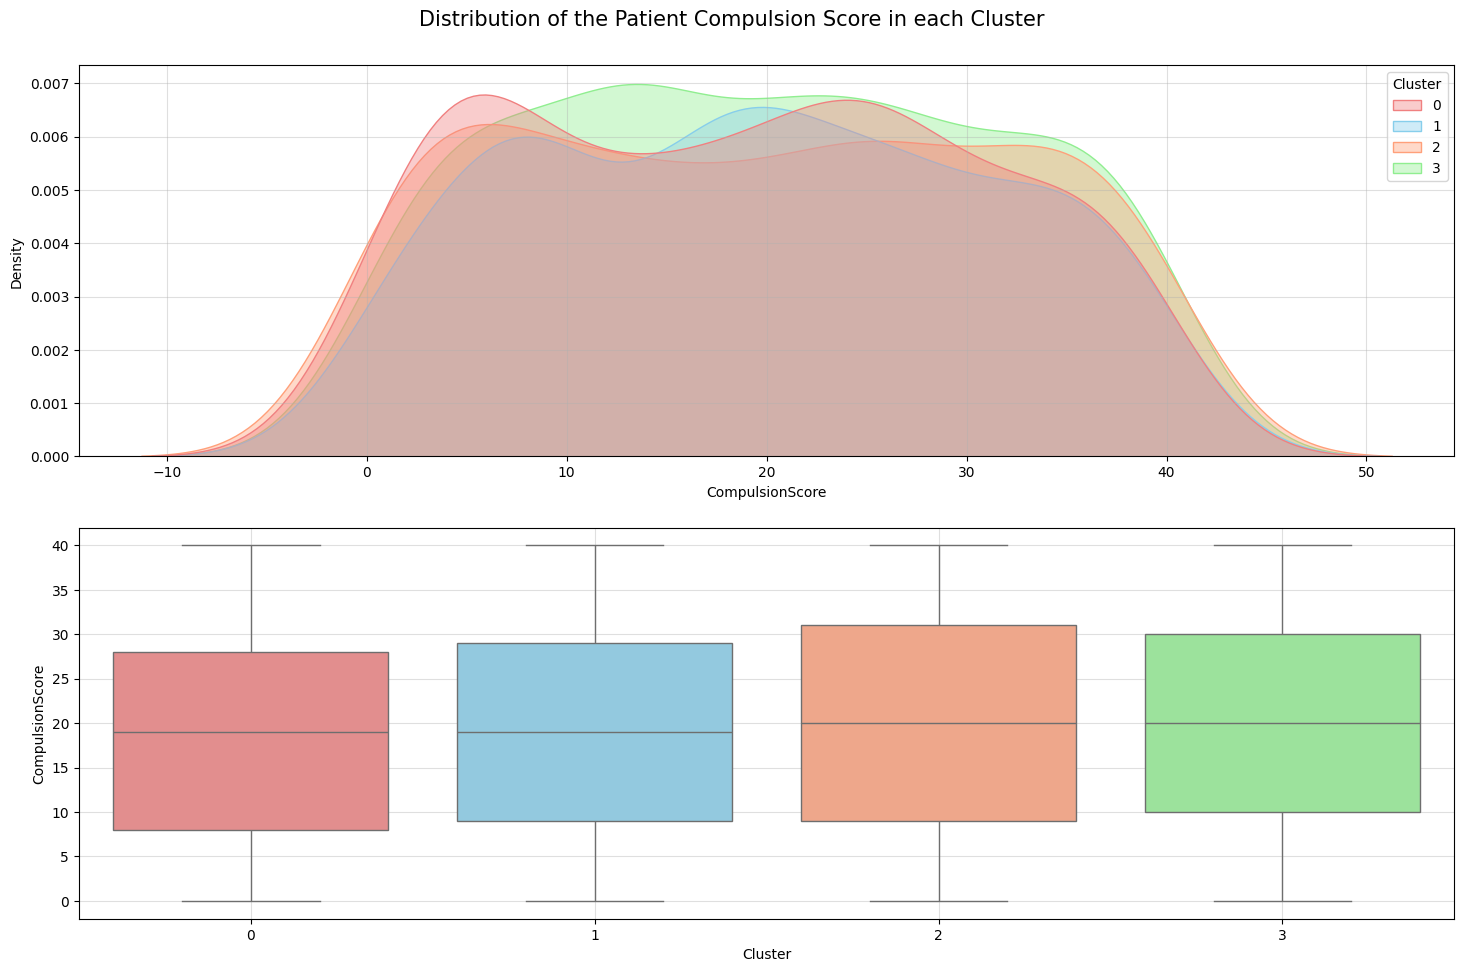

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,376.0,18.981383,11.743579,0.0,8.0,19.0,28.0,40.0
1,349.0,19.767908,11.439019,0.0,9.0,19.0,29.0,40.0
2,375.0,19.674667,12.295200,0.0,9.0,20.0,31.0,40.0
3,400.0,20.062500,11.642485,0.0,10.0,20.0,30.0,40.0


In [18]:
# distribution of the patient obsession score in each cluster
figure, axes = plt.subplots(2,1, figsize=(15,10))
sns.kdeplot(data=data, x=data['CompulsionScore'], hue=data['Cluster'], palette=colors, fill=True, alpha=0.4, ax=axes[0])
axes[0].grid(alpha=0.4)
sns.boxplot(data=data, x=data['Cluster'], y=data['CompulsionScore'], palette=colors, ax=axes[1])
axes[1].grid(alpha=0.4)
figure.suptitle('Distribution of the Patient Compulsion Score in each Cluster', fontsize=15)
plt.tight_layout(pad=2)
plt.show()

# display the summary statistic
pt_cluster = data.groupby('Cluster')
display(pt_cluster.CompulsionScore.describe())

#### Characteristic 5 | Patient's Gender in each Cluster

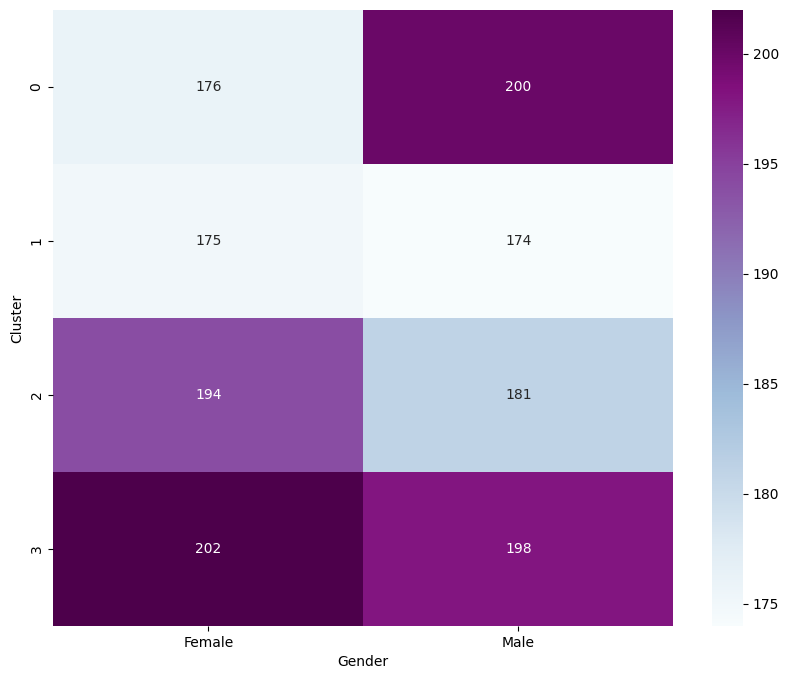

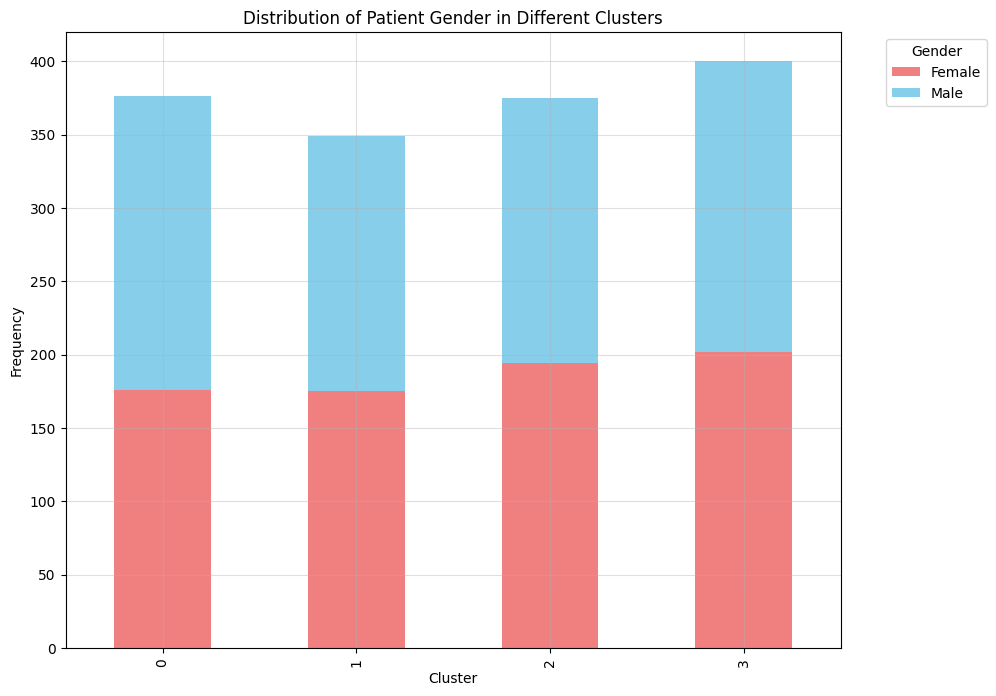

In [19]:
# distribution of patient's gender in each cluster
gender_crosstab = pd.crosstab(data['Cluster'], data['Gender'])

# display the cross table in heatmap
plt.figure(figsize=(10,8))
sns.heatmap(gender_crosstab, annot=True, fmt='.4g', cmap='BuPu')
plt.show()

# visalization (stacked bar chart)
gender_crosstab.plot(kind='bar', stacked=True, color=colors, figsize=(10,8))
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Distribution of Patient Gender in Different Clusters')
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.4)
plt.show()

#### Characteristic 6 | Patient's Ethnicity in each Cluster

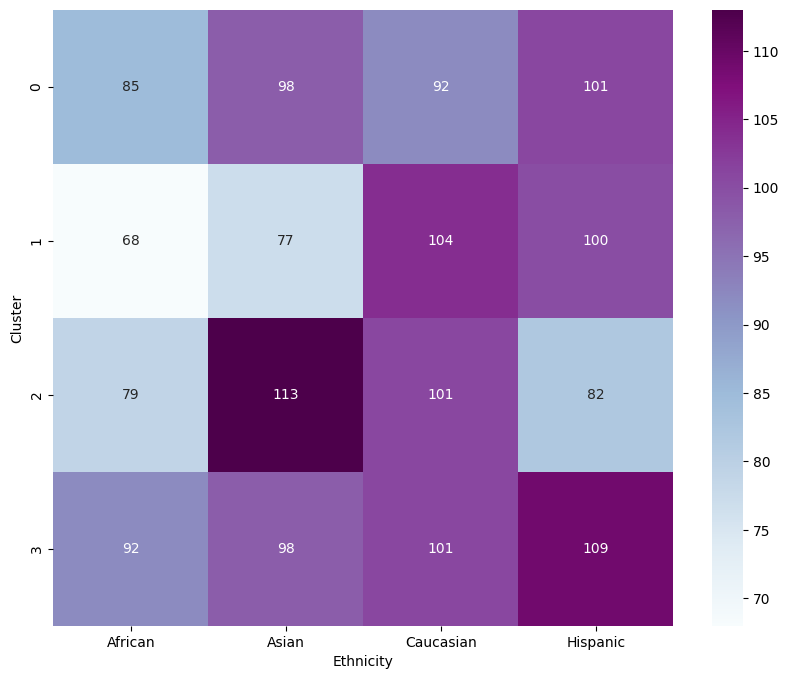

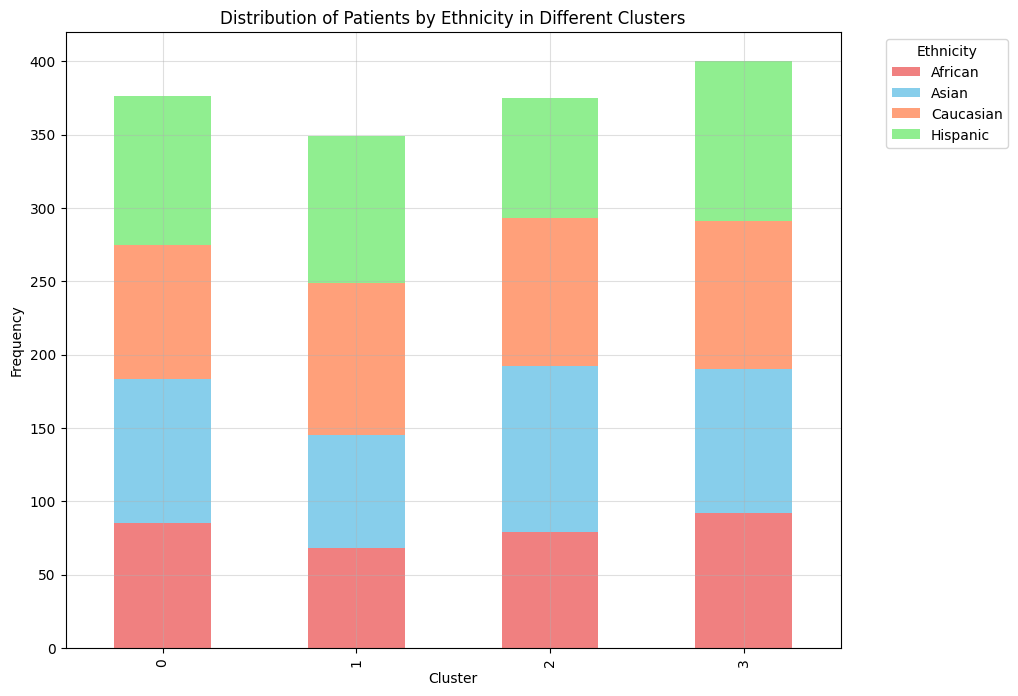

In [20]:
# distribution of patient's ethnicity in each cluster
ethnic_crosstab = pd.crosstab(data['Cluster'], data['Ethnicity'])

# display the cross table in heatmap
plt.figure(figsize=(10,8))
sns.heatmap(ethnic_crosstab, annot=True, fmt='.4g', cmap='BuPu')
plt.show()

# visalization (stacked bar chart)
ethnic_crosstab.plot(kind='bar', stacked=True, color=colors, figsize=(10,8))
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Distribution of Patients by Ethnicity in Different Clusters')
plt.legend(title='Ethnicity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.4)
plt.show()

#### Characteristic 7 | Distribution of Patient's Education Level in each Cluster

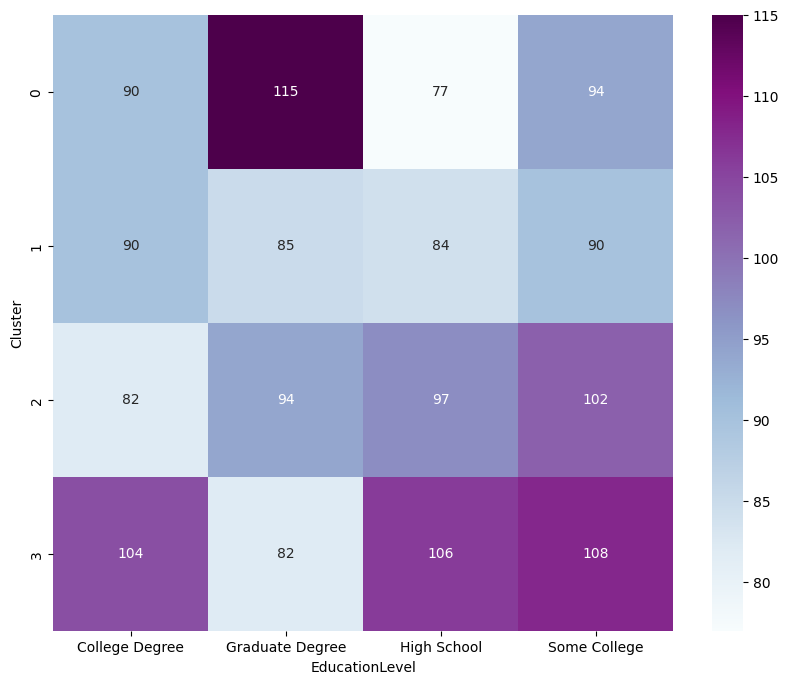

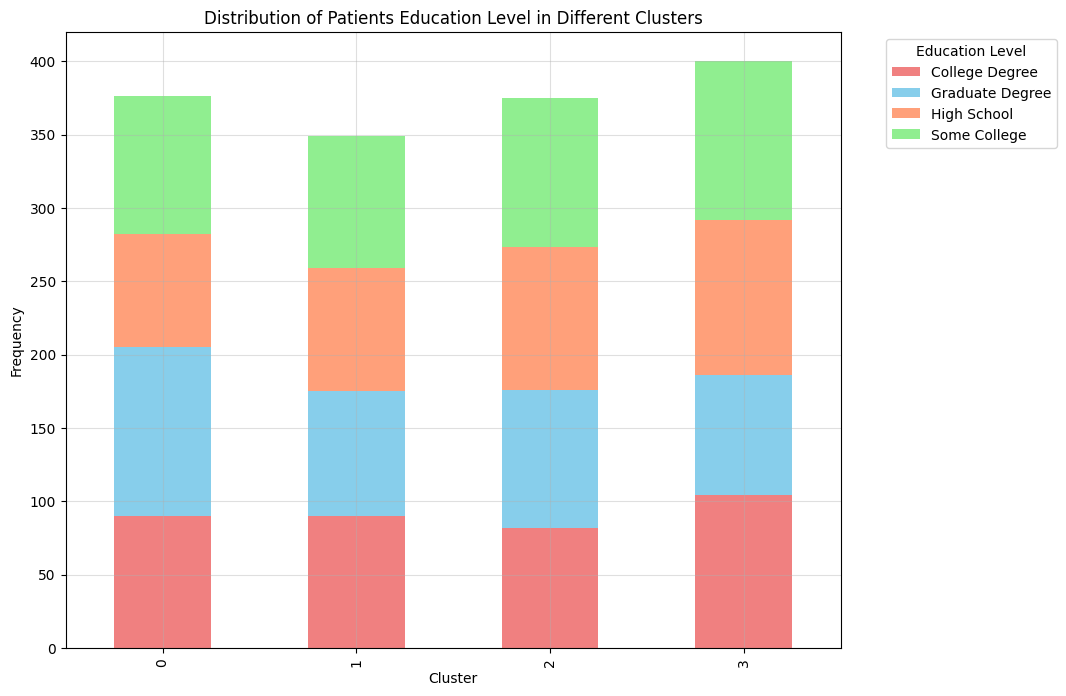

In [21]:
# distribution of patient's education level in each cluster
educ_crosstab = pd.crosstab(data['Cluster'], data['EducationLevel'])

# display the cross table in heatmap
plt.figure(figsize=(10,8))
sns.heatmap(educ_crosstab, annot=True, fmt='.4g', cmap='BuPu')
plt.show()

# visalization (stacked bar chart)
educ_crosstab.plot(kind='bar', stacked=True, color=colors, figsize=(10,8))
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Distribution of Patients Education Level in Different Clusters')
plt.legend(title='Education Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.4)
plt.show()

#### Characteristic 8 | Distribution of Patient's Marital Status in each Cluster

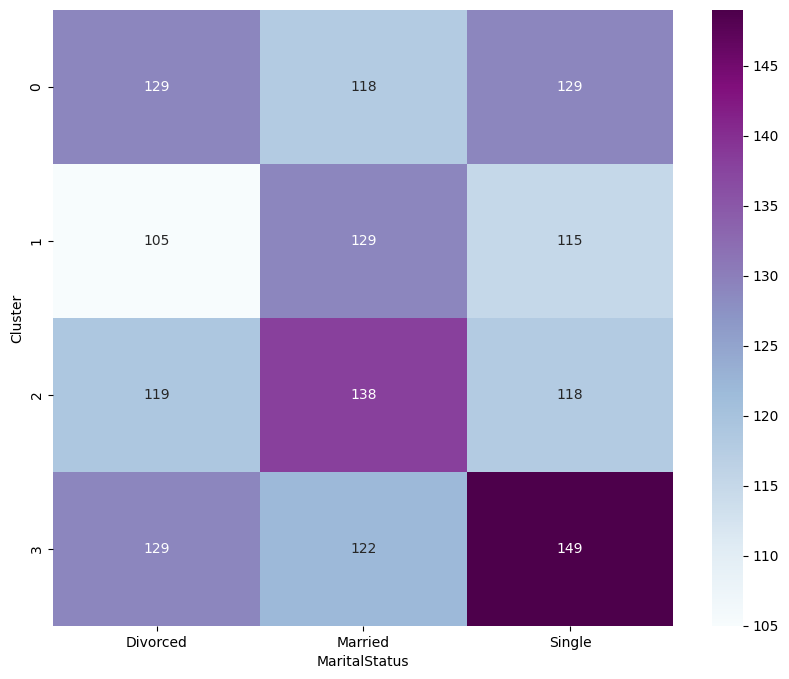

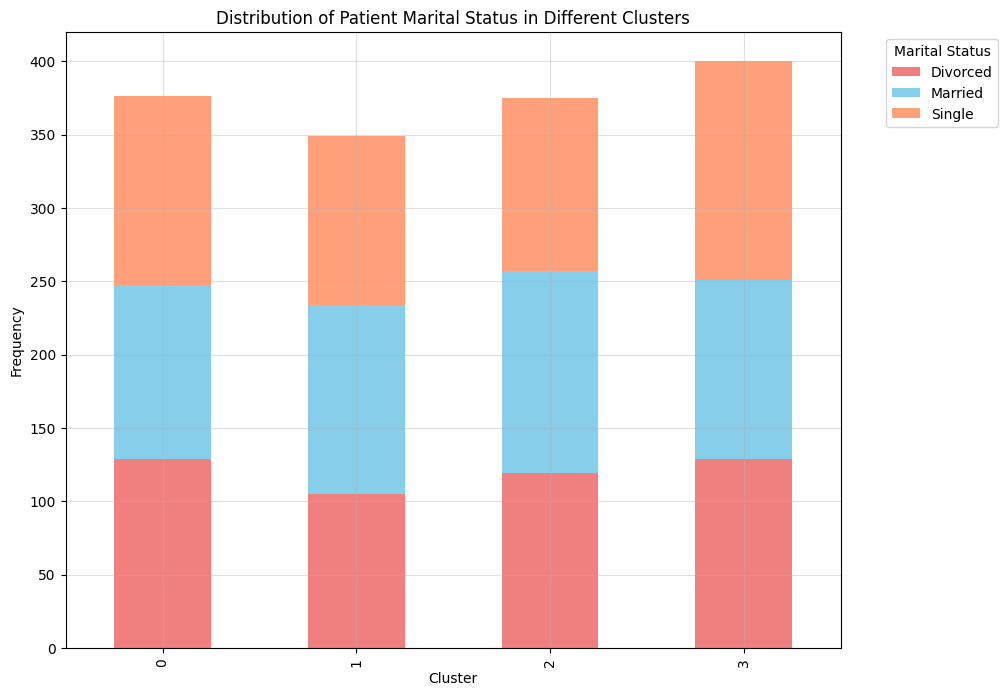

In [22]:
# distribution of patient's gender in each cluster
marital_crosstab = pd.crosstab(data['Cluster'], data['MaritalStatus'])

# display the cross table in heatmap
plt.figure(figsize=(10,8))
sns.heatmap(marital_crosstab, annot=True, fmt='.4g', cmap='BuPu')
plt.show()

# visalization (stacked bar chart)
marital_crosstab.plot(kind='bar', stacked=True, color=colors, figsize=(10,8))
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Distribution of Patient Marital Status in Different Clusters')
plt.legend(title='Marital Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.4)
plt.show()

#### Characteristic 9 | Distribution of Patient's Previous Diagnosis in each Cluster

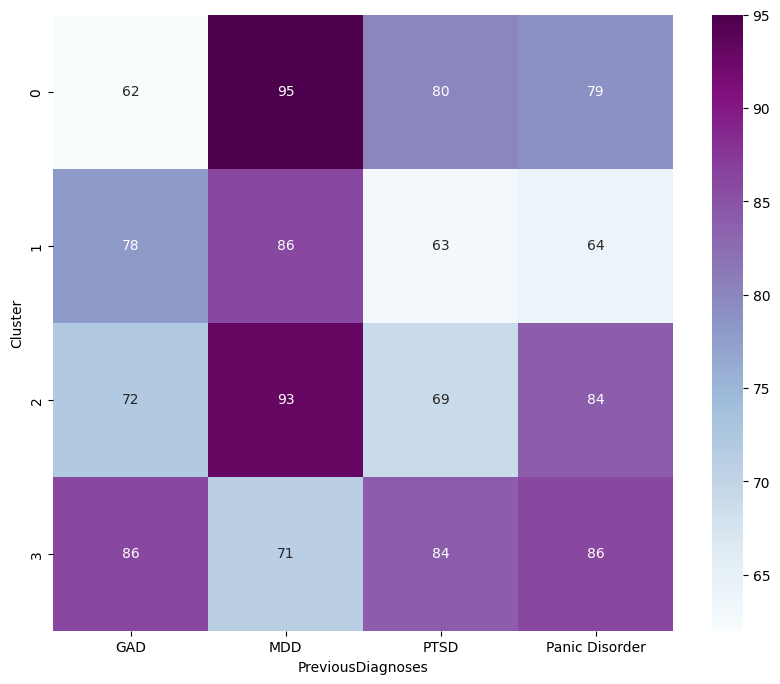

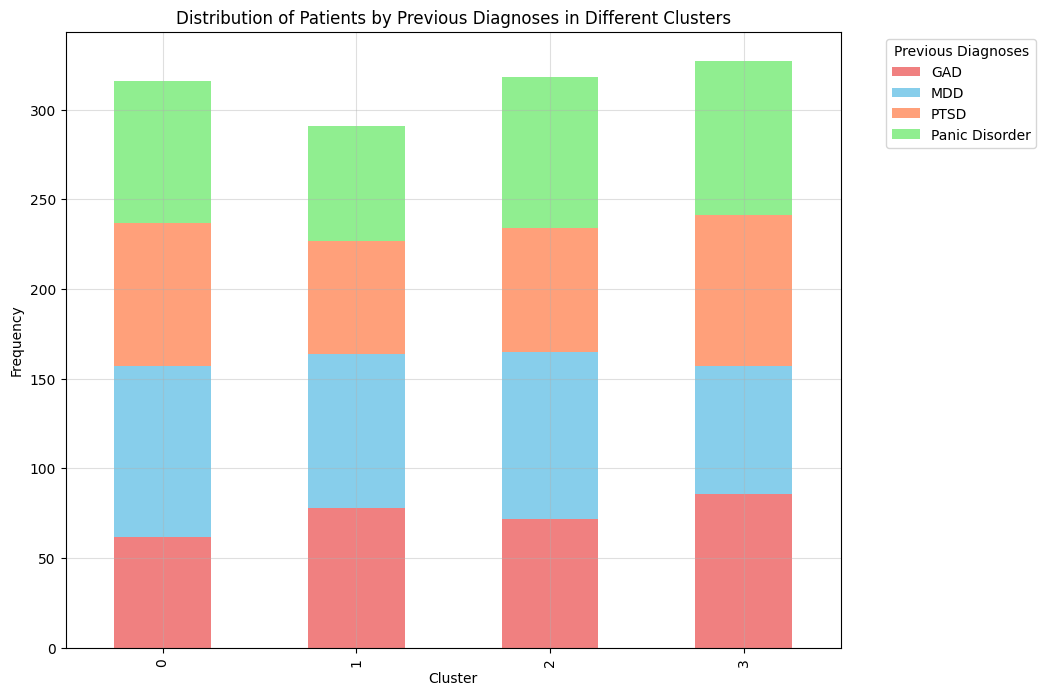

In [23]:
colors = ['lightcoral','skyblue','lightsalmon','lightgreen', 'violet']

# distribution of various previous diagnoses in each cluster
diagnose_crosstab = pd.crosstab(data['Cluster'], data['PreviousDiagnoses'])

# display the cross table in heatmap
plt.figure(figsize=(10,8))
sns.heatmap(diagnose_crosstab, annot=True, fmt='.4g', cmap='BuPu')
plt.show()

# visalization (stacked bar chart)
diagnose_crosstab.plot(kind='bar', stacked=True, color=colors, figsize=(10,8))
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Distribution of Patients by Previous Diagnoses in Different Clusters')
plt.legend(title='Previous Diagnoses', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.4)
plt.show()

#### Characteristic 10 | Distribution of Patient's Family History in each Cluster

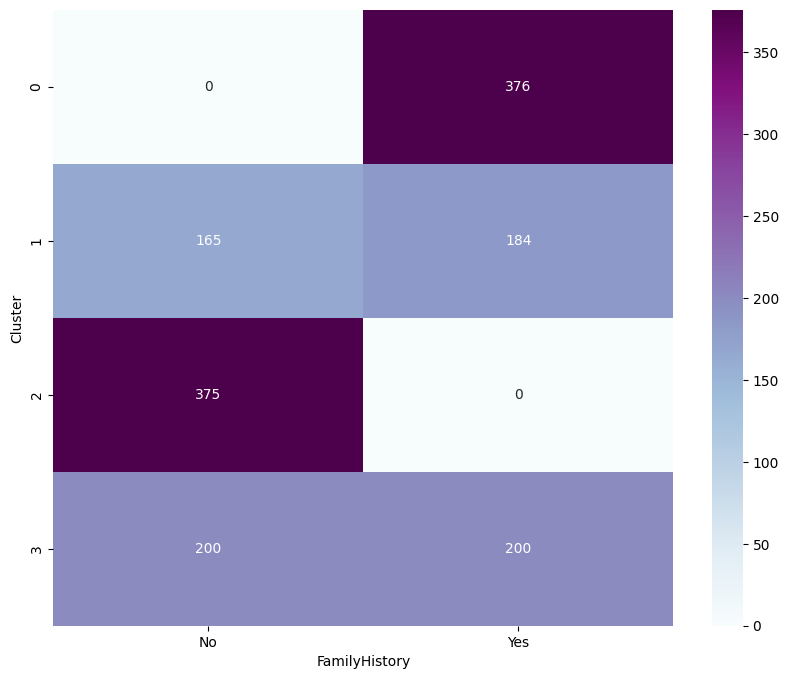

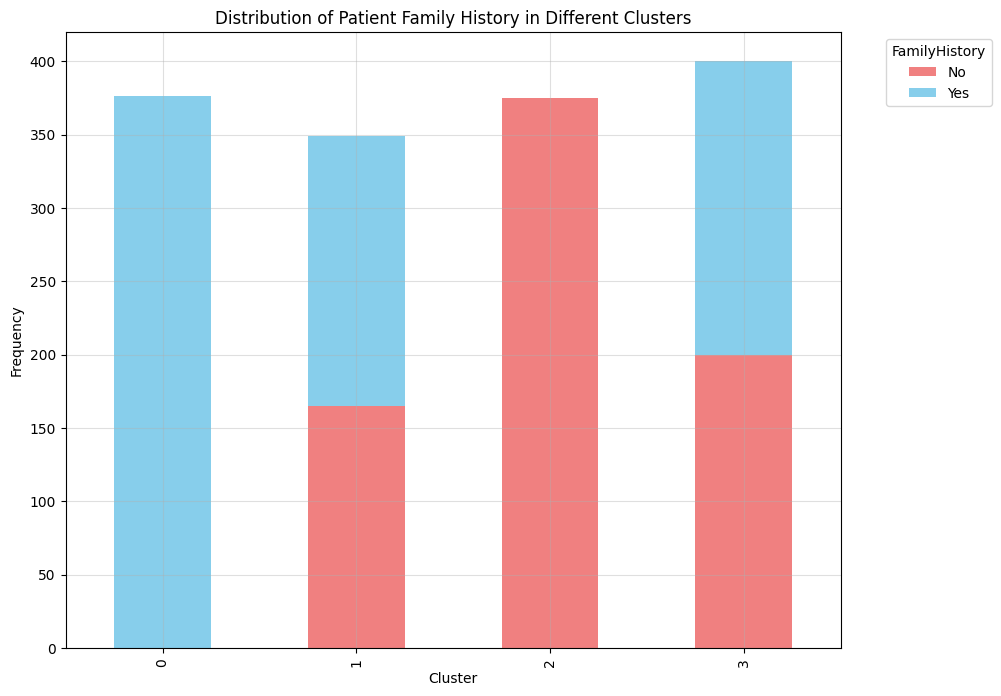

In [24]:
# distribution of patient's family history in each cluster
history_crosstab = pd.crosstab(data['Cluster'], data['FamilyHistory'])

# display the cross table in heatmap
plt.figure(figsize=(10,8))
sns.heatmap(history_crosstab, annot=True, fmt='.4g', cmap='BuPu')
plt.show()

# visalization (stacked bar chart)
history_crosstab.plot(kind='bar', stacked=True, color=colors, figsize=(10,8))
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Distribution of Patient Family History in Different Clusters')
plt.legend(title='FamilyHistory', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.4)
plt.show()

#### Characteristic 11 | Patient's Obsession Type in each Cluster

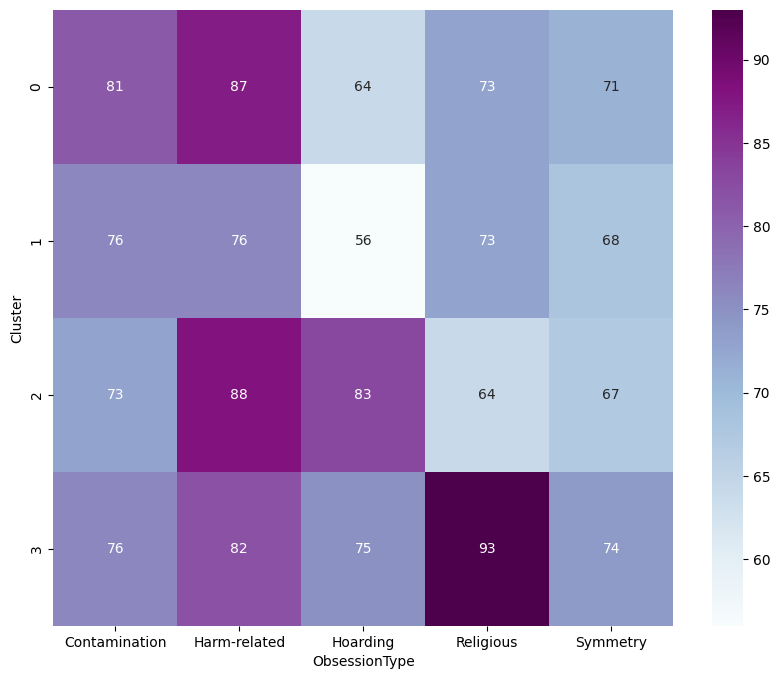

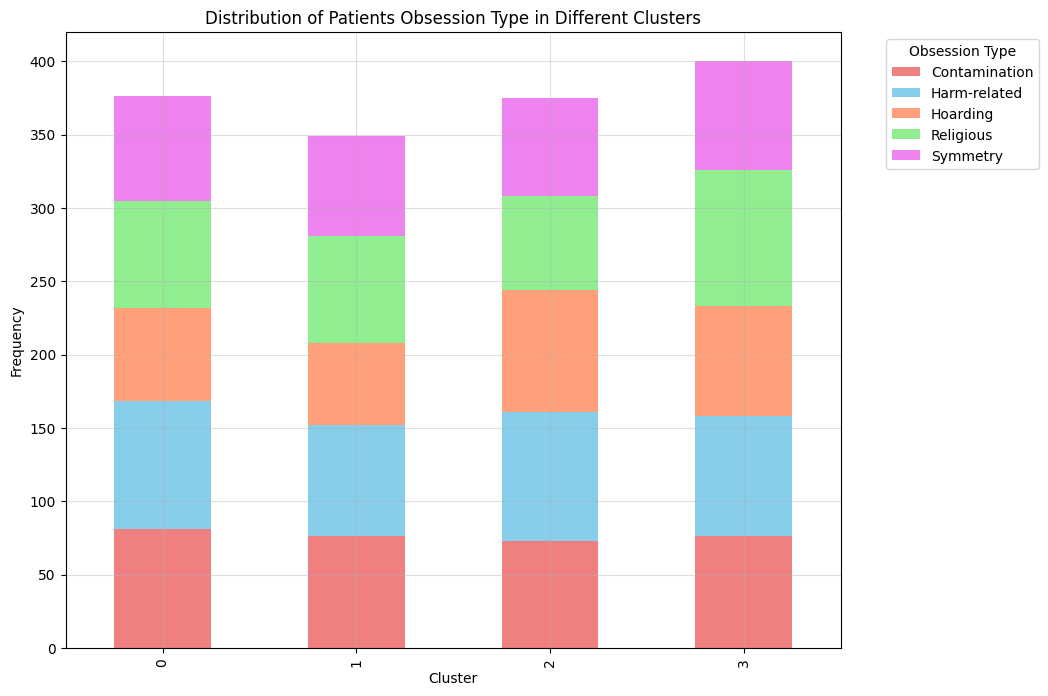

In [25]:
# distribution of patient's obsession type in each cluster
obsession_crosstab = pd.crosstab(data['Cluster'], data['ObsessionType'])

# display the cross table in heatmap
plt.figure(figsize=(10,8))
sns.heatmap(obsession_crosstab, annot=True, fmt='.4g', cmap='BuPu')
plt.show()

# visalization (stacked bar chart)
obsession_crosstab.plot(kind='bar', stacked=True, color=colors, figsize=(10,8))
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Distribution of Patients Obsession Type in Different Clusters')
plt.legend(title='Obsession Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.4)
plt.show()

#### Characteristic 12 | Patient's Compulsion Type in each Cluster

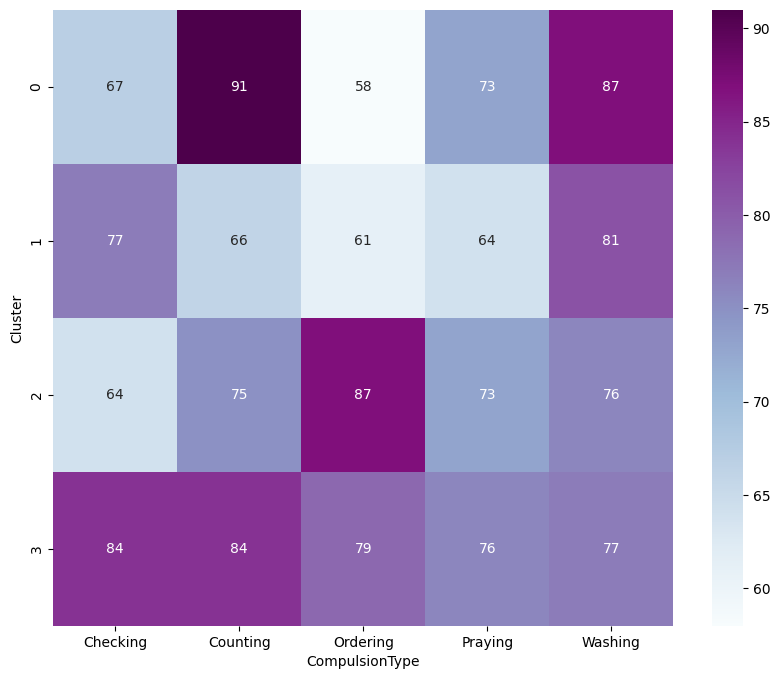

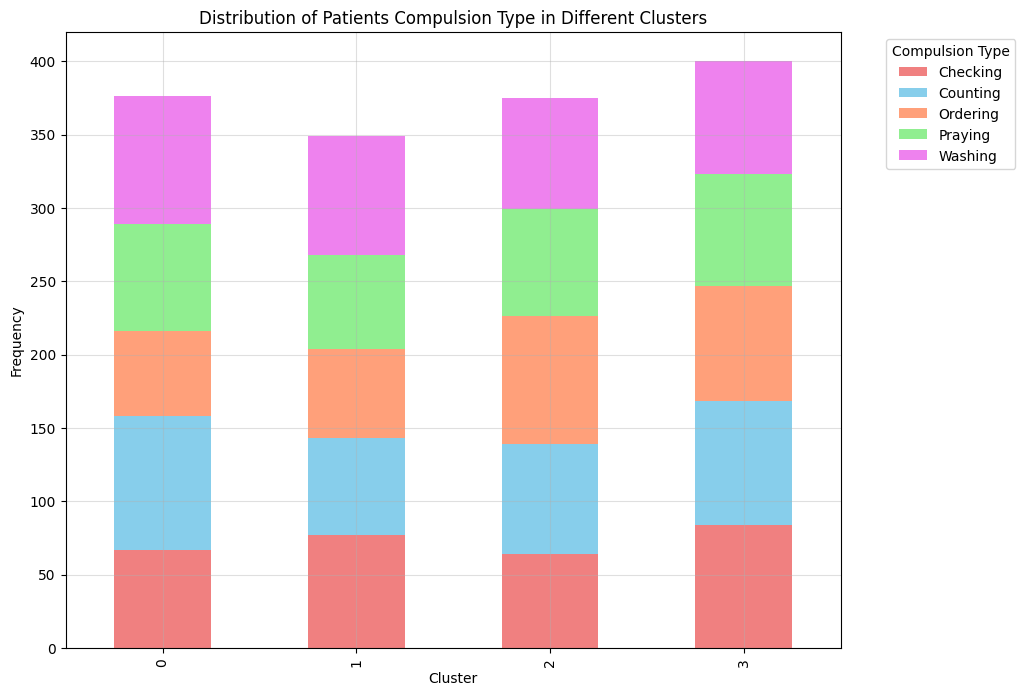

In [26]:
# distribution of patient's compulsion type in each cluster
compulsion_crosstab = pd.crosstab(data['Cluster'], data['CompulsionType'])

# display the cross table in heatmap
plt.figure(figsize=(10,8))
sns.heatmap(compulsion_crosstab, annot=True, fmt='.4g', cmap='BuPu')
plt.show()

# visalization (stacked bar chart)
compulsion_crosstab.plot(kind='bar', stacked=True, color=colors, figsize=(10,8))
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Distribution of Patients Compulsion Type in Different Clusters')
plt.legend(title='Compulsion Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.4)
plt.show()

#### Characteristic 13 | Patient's Depression Diagnosis in each Cluster

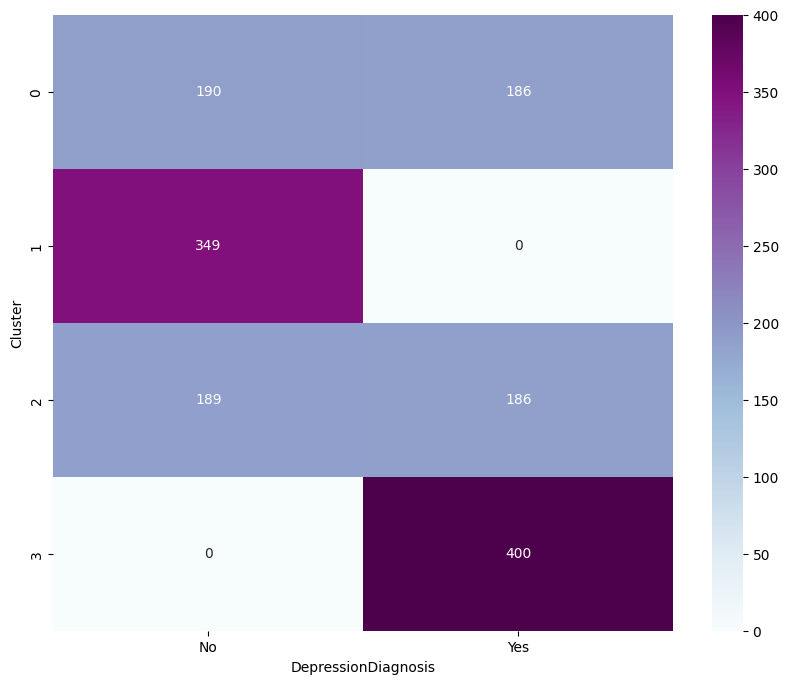

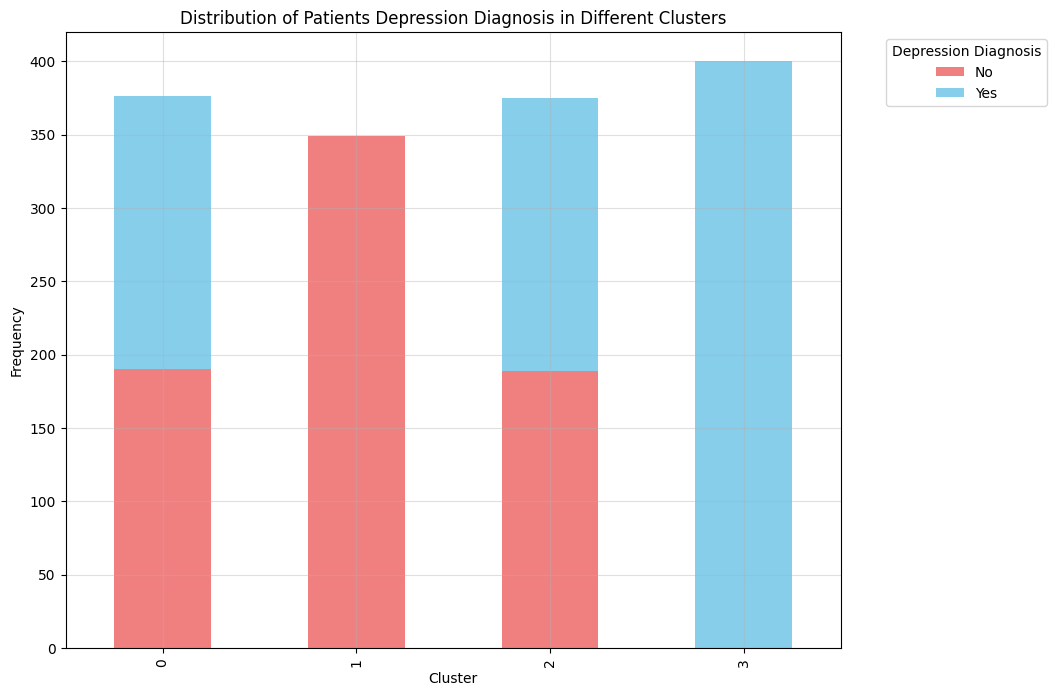

In [27]:
# distribution of patient's depression diagnosis in each cluster
depression_crosstab = pd.crosstab(data['Cluster'], data['DepressionDiagnosis'])

# display the cross table in heatmap
plt.figure(figsize=(10,8))
sns.heatmap(depression_crosstab, annot=True, fmt='.4g', cmap='BuPu')
plt.show()

# visalization (stacked bar chart)
depression_crosstab.plot(kind='bar', stacked=True, color=colors, figsize=(10,8))
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Distribution of Patients Depression Diagnosis in Different Clusters')
plt.legend(title='Depression Diagnosis', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.4)
plt.show()

#### Characteristic 14 | Patient's Anxiety Diagnosis in each Cluster

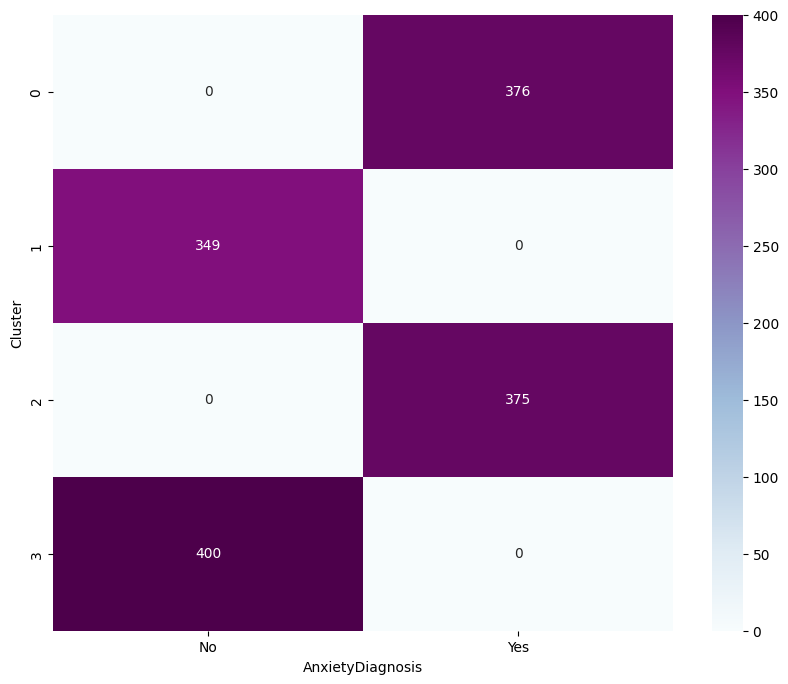

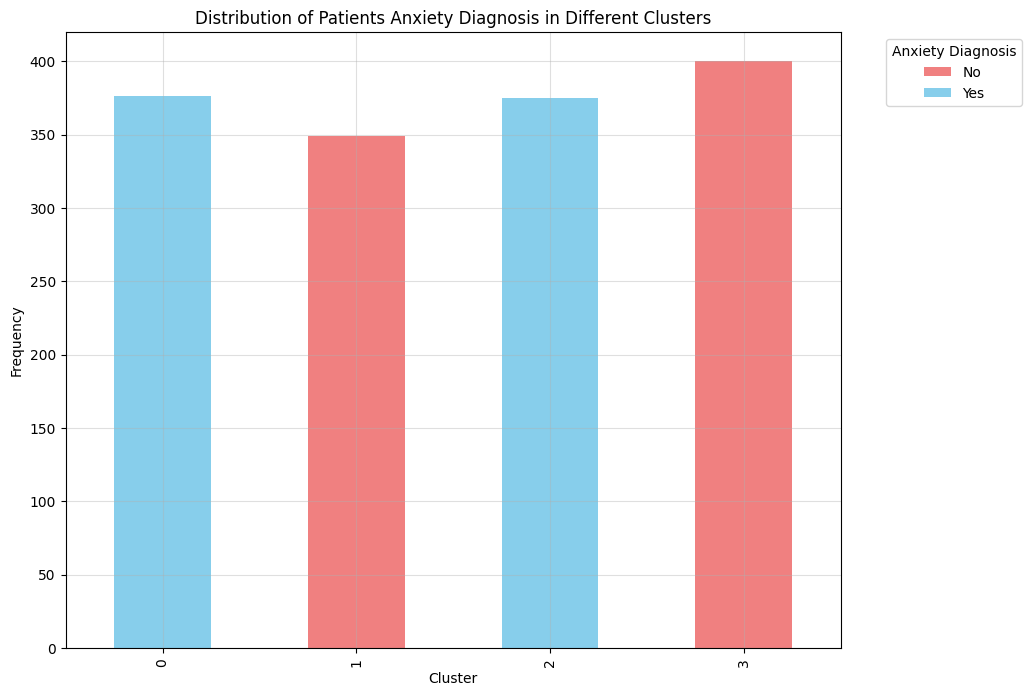

In [28]:
# distribution of patient's anxiety diagnosis in each cluster
anxiety_crosstab = pd.crosstab(data['Cluster'], data['AnxietyDiagnosis'])

# display the cross table in heatmap
plt.figure(figsize=(10,8))
sns.heatmap(anxiety_crosstab, annot=True, fmt='.4g', cmap='BuPu')
plt.show()

# visalization (stacked bar chart)
anxiety_crosstab.plot(kind='bar', stacked=True, color=colors, figsize=(10,8))
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Distribution of Patients Anxiety Diagnosis in Different Clusters')
plt.legend(title='Anxiety Diagnosis', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.4)
plt.show()

#### Characteristic 15 | Medications used by Patients in each Cluster

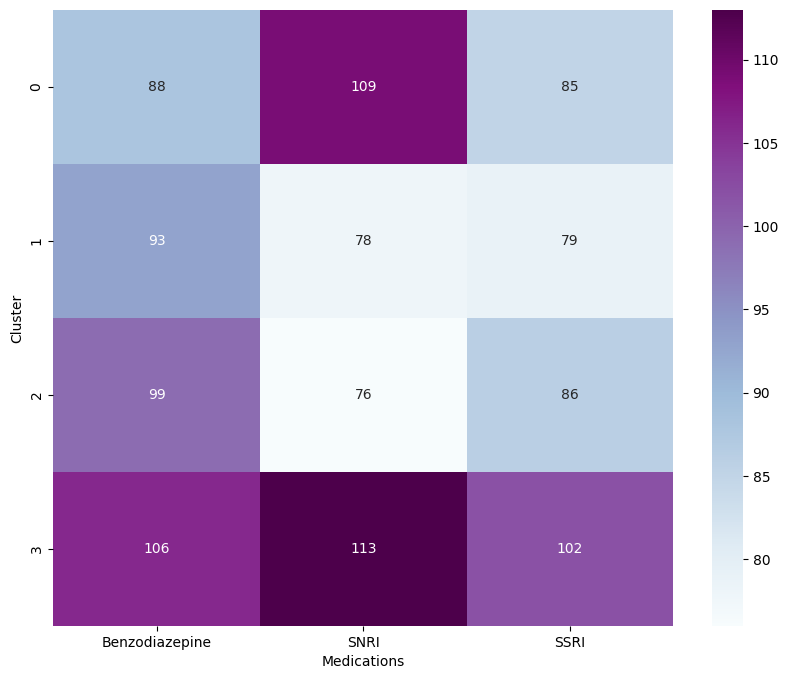

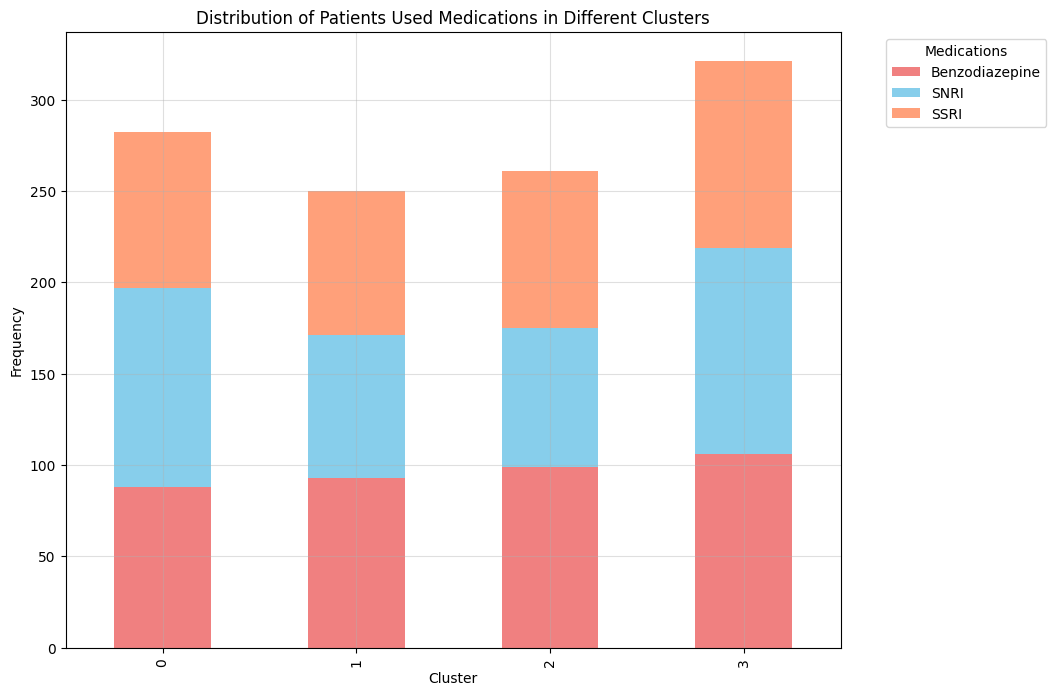

In [29]:
# distribution of patient's used medication in each cluster
medication_crosstab = pd.crosstab(data['Cluster'], data['Medications'])

# display the cross table in heatmap
plt.figure(figsize=(10,8))
sns.heatmap(medication_crosstab, annot=True, fmt='.4g', cmap='BuPu')
plt.show()

# visalization (stacked bar chart)
medication_crosstab.plot(kind='bar', stacked=True, color=colors, figsize=(10,8))
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Distribution of Patients Used Medications in Different Clusters')
plt.legend(title='Medications', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.4)
plt.show()

In [31]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split


In [32]:
# Assuming data_processed contains preprocessed features and patientLabel contains cluster labels
X = data_processed  # Features
y = patientLabel    # Cluster labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [33]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')  # 4 clusters, so final layer has 4 neurons with softmax activation
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2624      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 4836 (18.89 KB)
Trainable params: 4836 (18.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
38/38 [==============================] - 2s 18ms/step - loss: 1.3389 - accuracy: 0.3225 - val_loss: 1.2054 - val_accuracy: 0.5600
Epoch 2/50
38/38 [==============================] - 0s 3ms/step - loss: 1.1070 - accuracy: 0.5917 - val_loss: 0.9156 - val_accuracy: 0.8867
Epoch 3/50
38/38 [==============================] - 0s 3ms/step - loss: 0.7666 - accuracy: 0.8008 - val_loss: 0.4756 - val_accuracy: 0.9833
Epoch 4/50
38/38 [==============================] - 0s 3ms/step - loss: 0.4426 - accuracy: 0.8908 - val_loss: 0.1817 - val_accuracy: 1.0000
Epoch 5/50
38/38 [==============================] - 0s 3ms/step - loss: 0.2262 - accuracy: 0.9633 - val_loss: 0.0706 - val_accuracy: 1.0000
Epoch 6/50
38/38 [==============================] - 0s 3ms/step - loss: 0.1285 - accuracy: 0.9767 - val_loss: 0.0321 - val_accuracy: 1.0000
Epoch 7/50
38/38 [==============================] - 0s 3ms/step - loss: 0.0809 - accuracy: 0.9892 - val_loss: 0.0168 - val_accuracy: 1.0000
Epoch 8/50
38/38 [=

10/10 [==============================] - 0s 3ms/step - loss: 1.4638e-05 - accuracy: 1.0000
Test Accuracy: 1.0


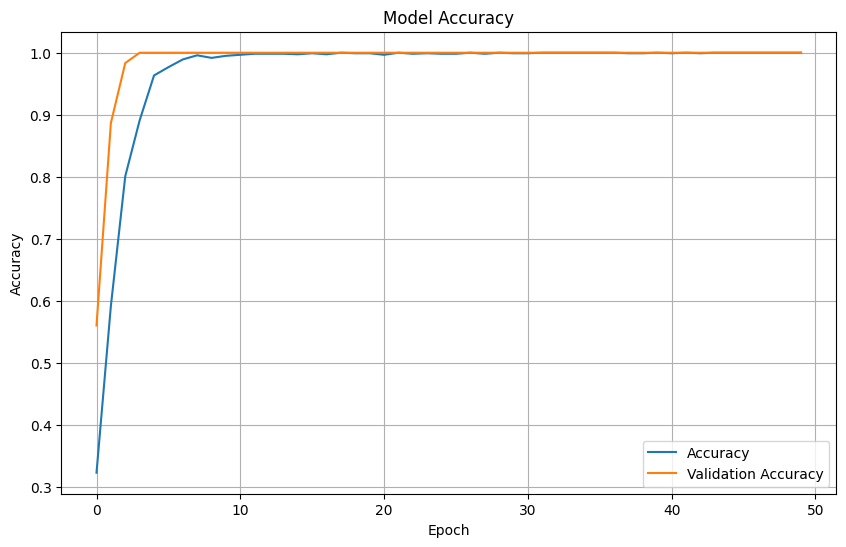

In [35]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

# Plot training history (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
